In [41]:
import numpy as np
import matplotlib.pyplot as plt
import visualization
from math import tan, atan, radians, degrees, sin, cos, atan2, asin, acos

In [2]:
# by https://stackoverflow.com/questions/2891790/how-to-pretty-printing-a-numpy-array-without-scientific-notation-and-with-given
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)
        

## constructing projection matrix

In [3]:
def construct_proj_matrix(H=1080, W=1914, fov=50.0, near_clip=1.5):
    # for z coord
    f = near_clip  # the near clip, but f in the book
    n = 10003.815  # the far clip, rounded value of median, after very weird values were discarded
    # x coord
    r = W * n * tan(radians(fov) / 2) / H
    l = -r
    # y coord
    t = n * tan(radians(fov) / 2)
    b = -t
    # x00 = 2*n/(r-l)
    x00 = H / (tan(radians(fov) / 2) * W)
    # x11 = 2*n/(t-b)
    x11 = 1 / tan(radians(fov) / 2)
    return np.array([
        [x00, 0, -(r + l) / (r - l), 0],
        [0, x11, -(t + b) / (t - b), 0],
        [0, 0, -f / (f - n), -f * n / (f - n)],
        [0, 0, -1, 0],
    ])

def calc_matrix_params(proj):
    x22 = proj[2, 2]
    x23 = proj[2, 3]
    n = -x23 / x22
    f = -x23 / (x22 - 1)
    return n, f

## loading data

In [55]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file

conn = visualization.get_connection()
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, imagepath, proj_matrix, view_matrix, \
    ARRAY[st_x(camera_pos), st_y(camera_pos), st_z(camera_pos)] as camera_pos, \
    ARRAY[st_x(camera_rot), st_y(camera_rot), st_z(camera_rot)] as camera_rot, \
    ARRAY[st_x(camera_direction), st_y(camera_direction), st_z(camera_direction)] as camera_direction \
  FROM snapshots \
  WHERE run_id = 6
  ORDER BY snapshot_id DESC \
  """)

results = []
for row in cur:
    res = dict(row)
    res['proj_matrix'] = np.array(res['proj_matrix'])
    res['view_matrix'] = np.array(res['view_matrix'])
    res['camera_pos'] = np.array(res['camera_pos'])
    res['camera_rot'] = np.array(res['camera_rot'])
    res['camera_direction'] = np.array(res['camera_direction'])
    results.append(res)

print('There are {} records'.format(len(results)))
projs = [i['proj_matrix'] for i in results]
views = [i['view_matrix'] for i in results]

# todo: estimate far plane by least squares. The rest is known. Before that, get rid of all outliers
# x00 = proj[0, 0]
# x11 = proj[1, 1]
x22s = np.array([proj[2, 2] for proj in projs])
x23s = np.array([proj[2, 3] for proj in projs])

ns = -x23s / x22s
fs = -x23s / (x22s - 1)

rotations = np.array([i['camera_rot'] for i in results])
positions = np.array([i['camera_pos'] for i in results])
directions = np.array([i['camera_direction'] for i in results])

print('all data prepared')

There are 33293 records
all data prepared


## inspecting projection matrix

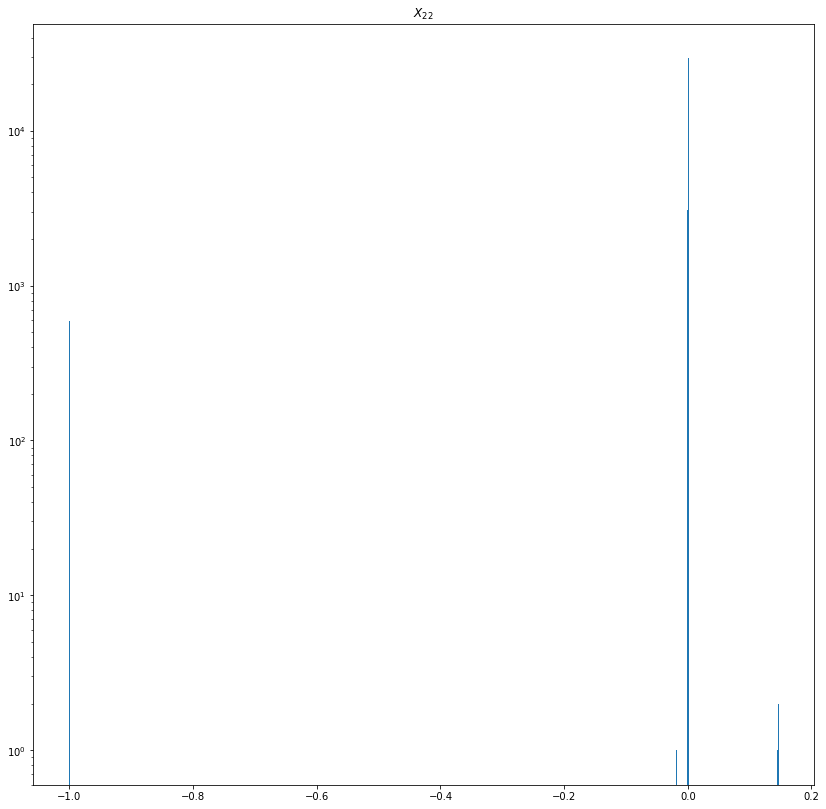

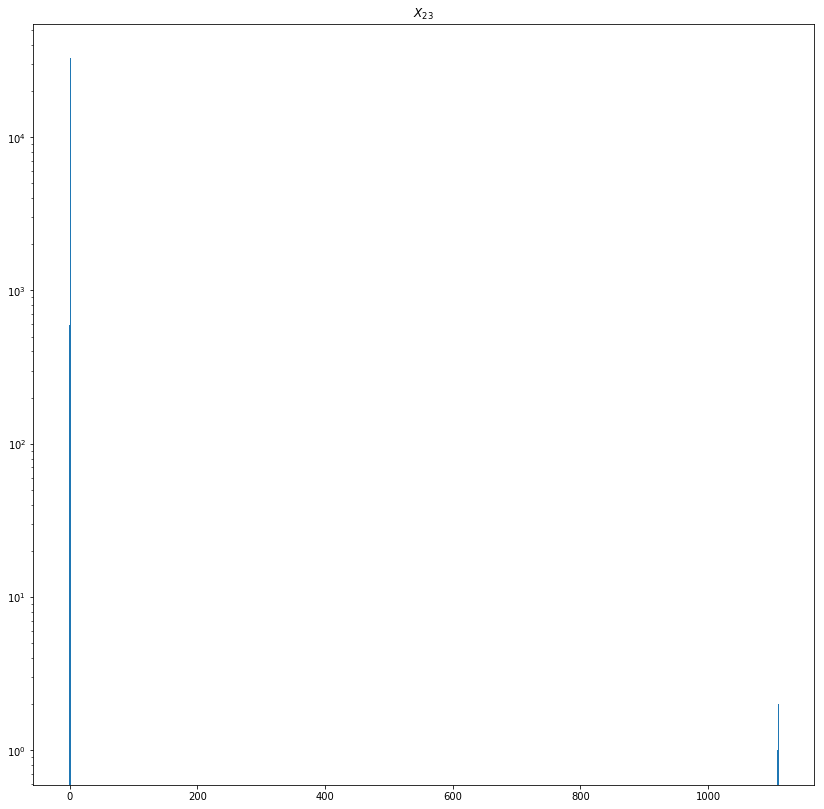

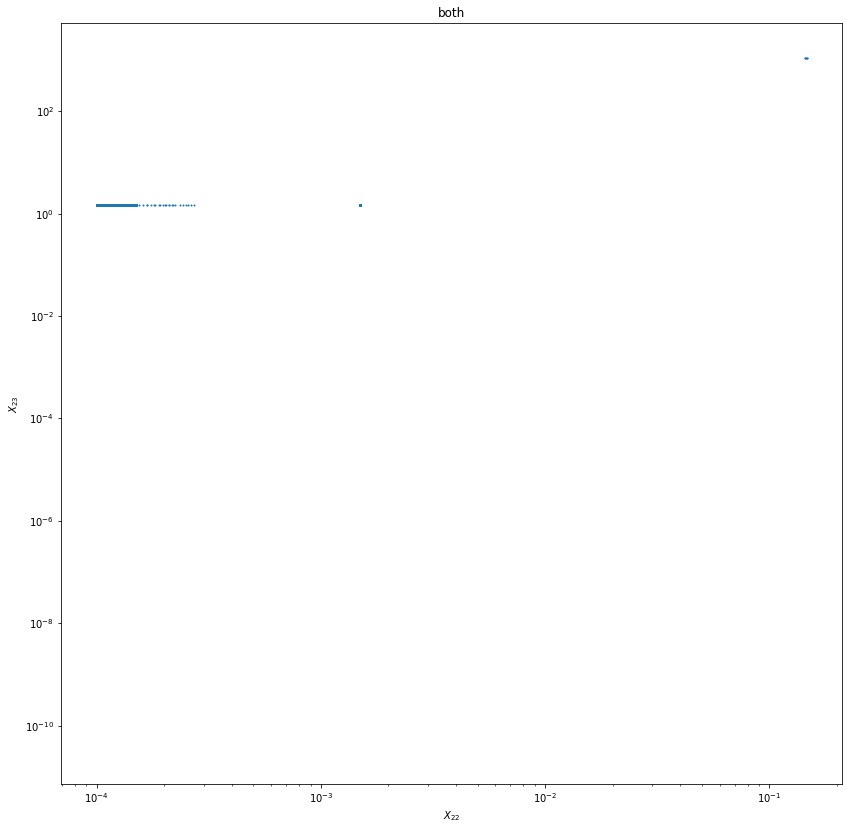

In [100]:
# showing plots with values
%matplotlib inline

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$X_{22}$')
plt.hist(x22s, bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$X_{23}$')
plt.hist(x23s, bins=1000)


fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$X_{22}$')
plt.ylabel('$X_{23}$')
plt.loglog(x22s, x23s, 'o', markersize=1)
plt.show()

In [101]:
# showing weird matrices
with printoptions(precision=5, suppress=True):
    print('weird x22 value in proj: ')
    weird_projs = [proj for proj in projs if abs(proj[2, 2] - (-1)) < 1e-4]
    for weird_proj in weird_projs:
        print(weird_proj)
        print(calc_matrix_params(weird_proj))
    
    print('correct proj')
    print(projs[0])
    print(calc_matrix_params(projs[0]))

    print('weird x23 value in proj: ')
    weird_projs = [proj for proj in projs if proj[2, 3] > 1000]
    for weird_proj in weird_projs:
        print(weird_proj)
        print(calc_matrix_params(weird_proj))
    
    print('correct proj')
    print(projs[0])
    print(calc_matrix_params(projs[0]))



weird x22 value in proj: 
[[ 1.21007 -0.       0.      -0.00003]
 [ 0.       2.14451 -0.      -0.     ]
 [ 0.      -0.      -1.      -0.00003]
 [-0.       0.      -1.       0.     ]]
(-2.8936579171896971e-05, -1.446828244810287e-05)
[[ 1.21007 -0.       0.      -0.00005]
 [ 0.       2.14451 -0.       0.00001]
 [ 0.      -0.      -1.       0.00007]
 [ 0.       0.      -1.       0.     ]]
(6.9314628883821911e-05, 3.4657296608361323e-05)
[[ 1.21007 -0.      -0.       0.00006]
 [ 0.       2.14451 -0.      -0.     ]
 [ 0.       0.      -1.      -0.00012]
 [ 0.       0.      -1.       0.     ]]
(-0.00012038641549108767, -6.0193176559244511e-05)
correct proj
[[ 1.21007  0.      -0.       0.0001 ]
 [ 0.       2.14451  0.       0.     ]
 [ 0.       0.       0.00015  1.50022]
 [ 0.       0.      -1.       0.     ]]
(-10003.814890496365, 1.5004499736000467)
weird x23 value in proj: 
[[    1.21007    -0.          0.         -0.00007]
 [    0.          2.14451    -0.         -0.     ]
 [    0.     

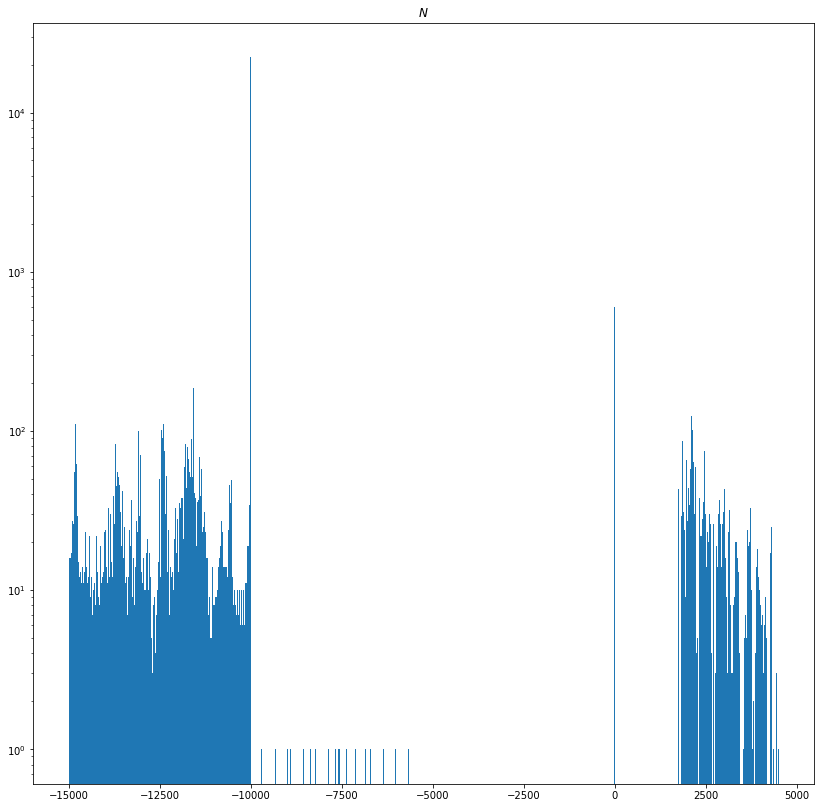

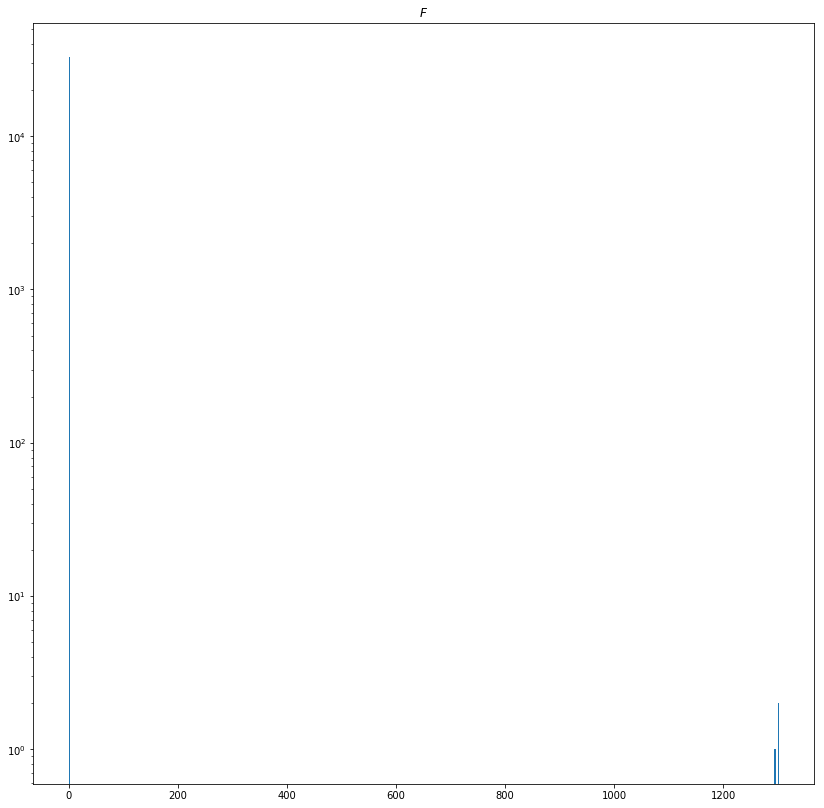

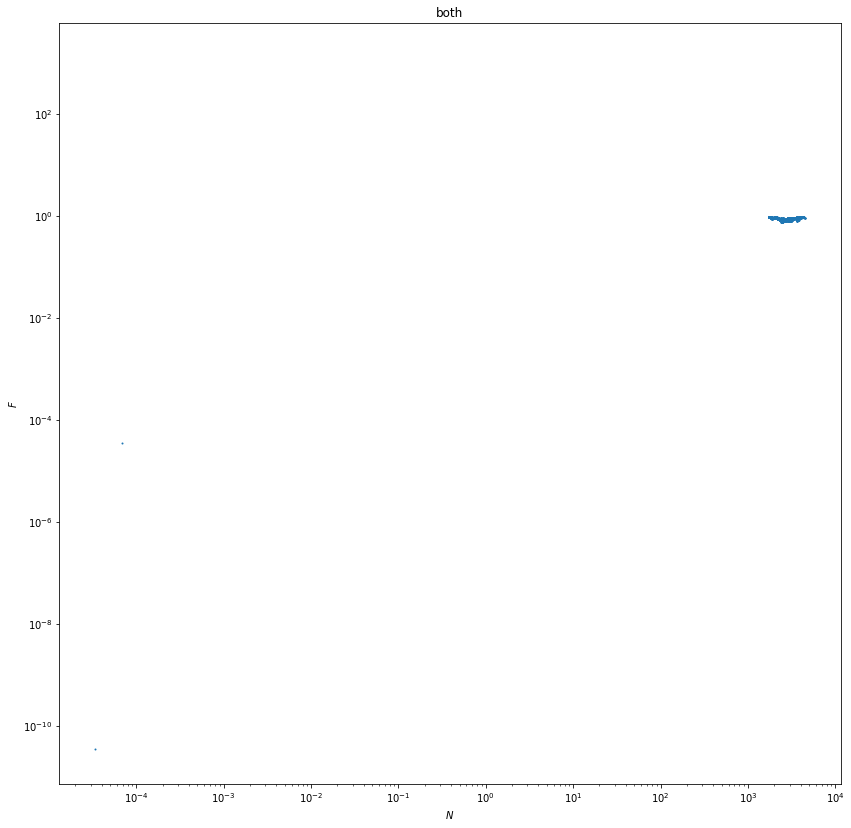

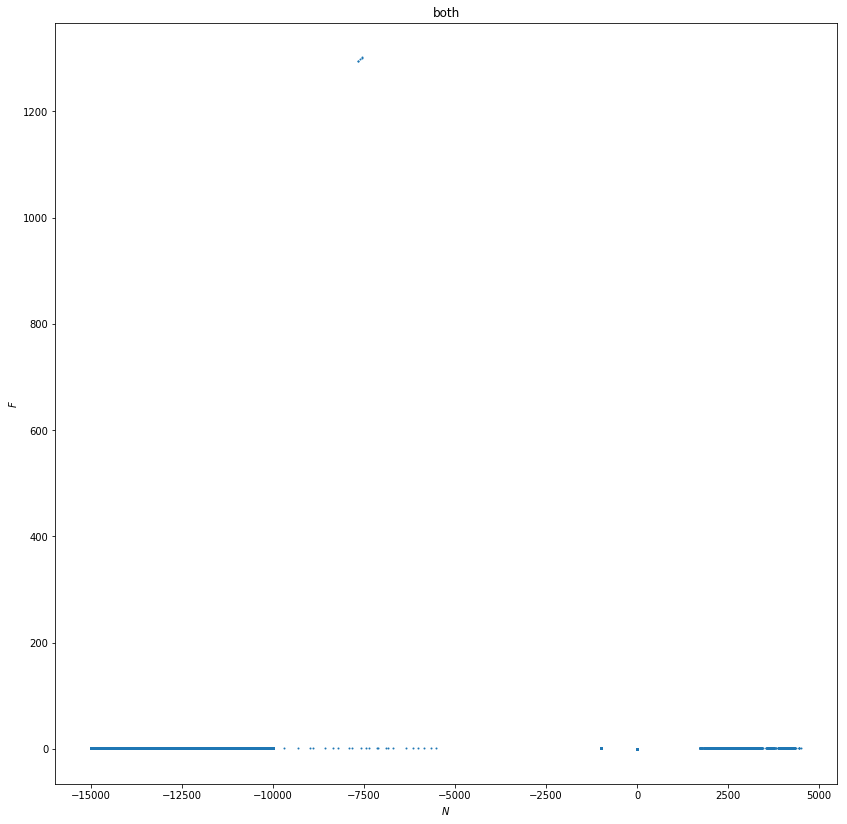

In [102]:
# showing plots with n and f
%matplotlib inline
# axes[0].plot(x22s, np.zeros_like(x22s), 'x')
fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$N$')
plt.hist(ns, bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$F$')
plt.hist(fs, bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$N$')
plt.ylabel('$F$')
plt.loglog(ns, fs, 'o', markersize=1)
plt.show()

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$N$')
plt.ylabel('$F$')
plt.plot(ns, fs, 'o', markersize=1)
plt.show()

In [103]:
# filtered weird values
# this filters only very weird values
correct_projs = [proj for proj in projs if abs(proj[2, 2] - (-1)) > 1e-2 and proj[2, 3] < 1e3]
# this filters bassed on knowledge of near clip (far clip in terminilogy of equations, f)
correct_projs = [proj for proj in correct_projs if abs((-proj[2, 3] / (proj[2, 2] - 1)) - 1.5) < 5e-4]
x22s = np.array([proj[2, 2] for proj in correct_projs])
x23s = np.array([proj[2, 3] for proj in correct_projs])

ns = -x23s / x22s
fs = -x23s / (x22s - 1)

print('all values count: ', len(projs))
print('correct values count: ', len(correct_projs))
print('filtered count: ', len(projs) - len(correct_projs))

all values count:  33293
correct values count:  29324
filtered count:  3969


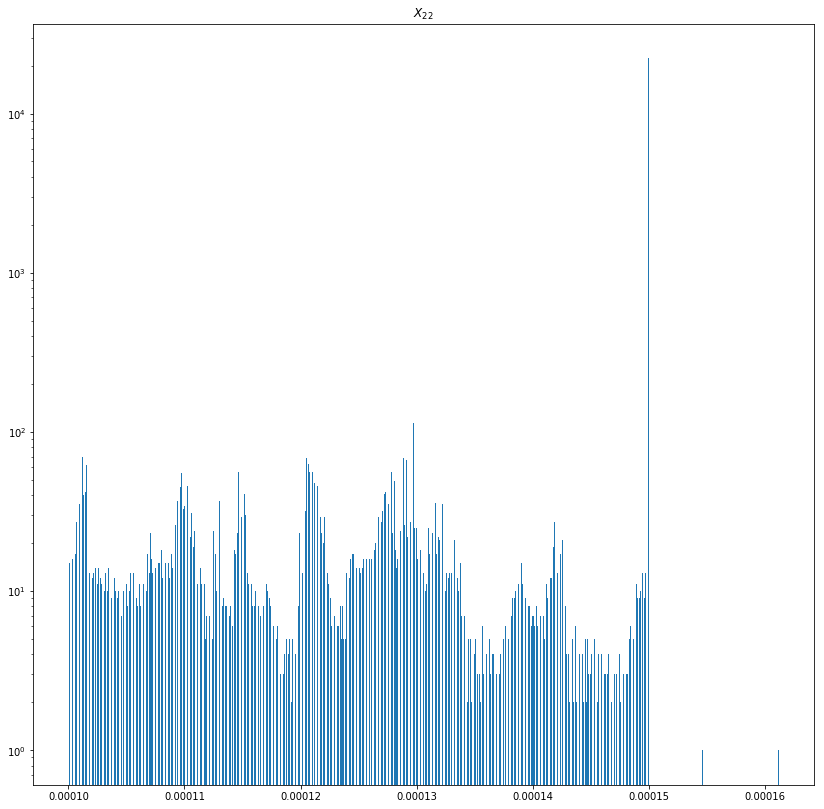

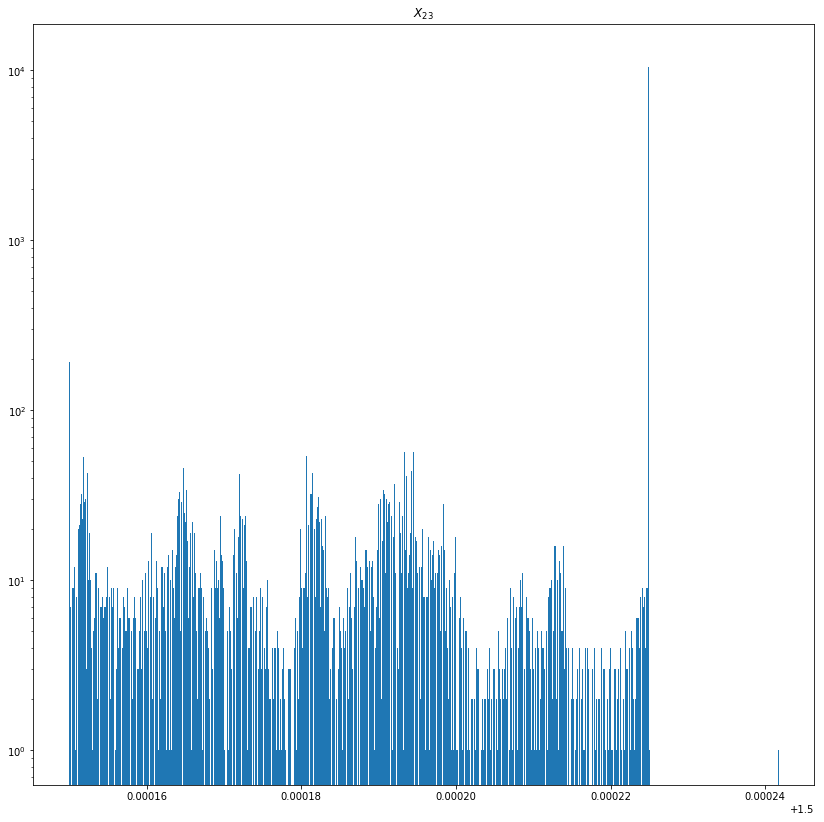

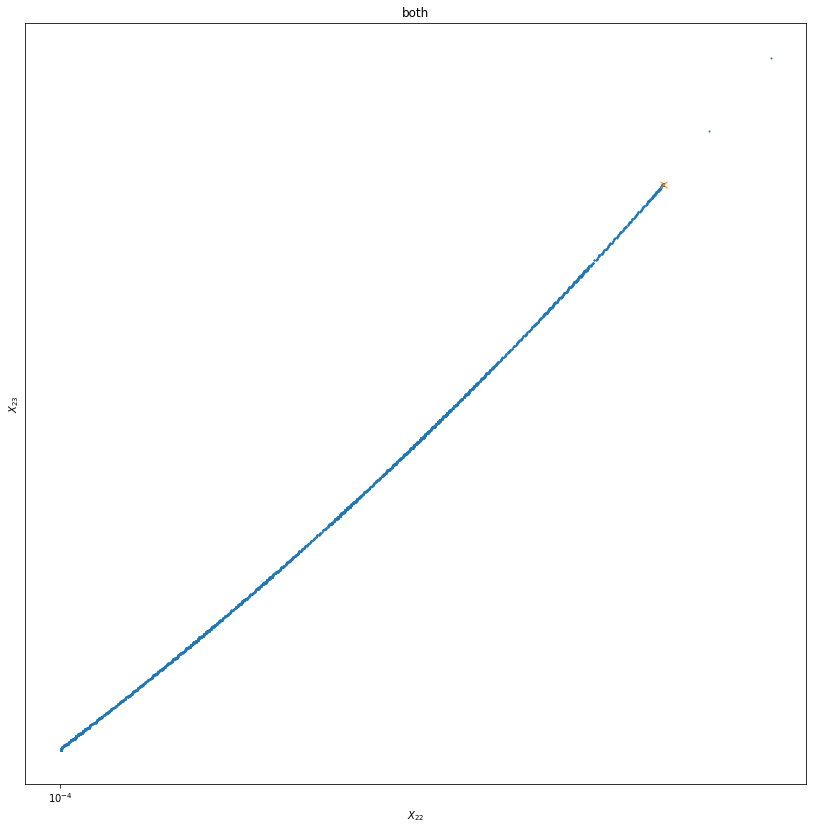

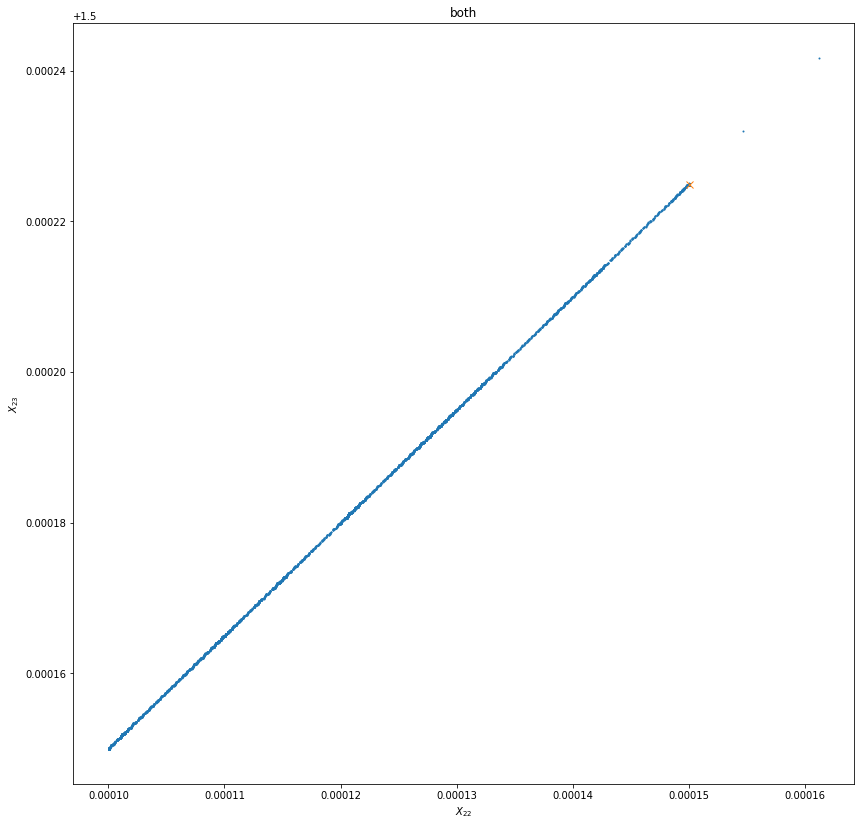

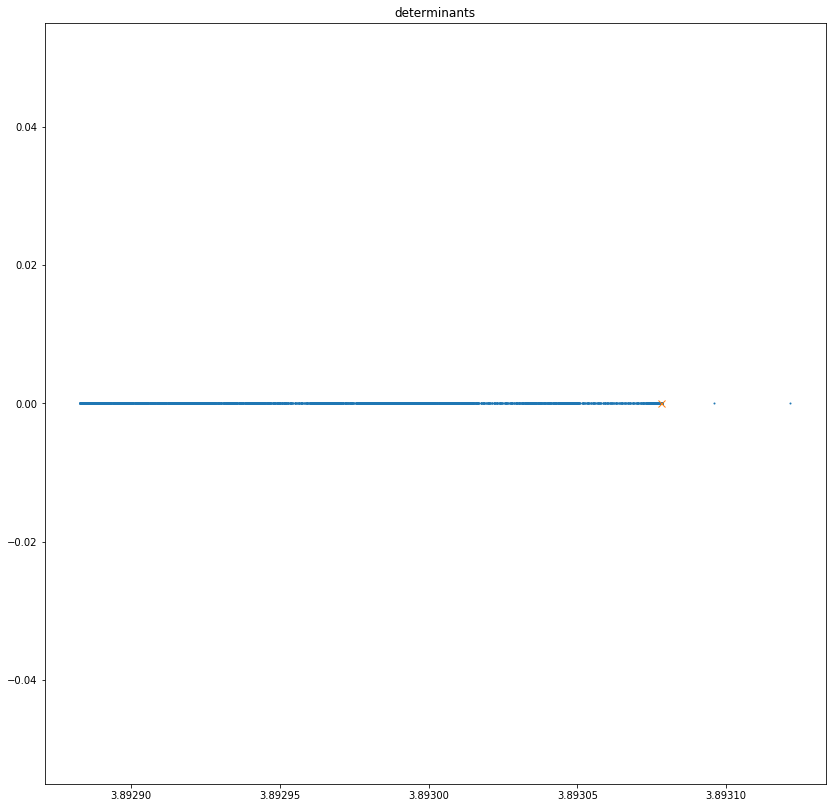

In [104]:
# showing plots with values
%matplotlib inline

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$X_{22}$')
plt.hist(x22s, bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$X_{23}$')
plt.hist(x23s, bins=1000)


my_proj = construct_proj_matrix()

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$X_{22}$')
plt.ylabel('$X_{23}$')
plt.loglog(x22s, x23s, 'o', markersize=1)
plt.plot(my_proj[2, 2], my_proj[2, 3], 'x', markersize=7)
plt.show()

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$X_{22}$')
plt.ylabel('$X_{23}$')
plt.plot(x22s, x23s, 'o', markersize=1)
plt.plot(my_proj[2, 2], my_proj[2, 3], 'x', markersize=7)
plt.show()

dets = [np.linalg.det(proj) for proj in correct_projs]
fig = plt.figure(figsize=(14, 14))
plt.title('determinants')
plt.plot(dets, np.zeros_like(dets), 'o', markersize=1)
plt.plot(np.linalg.det(my_proj), 0, 'x', markersize=7)
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


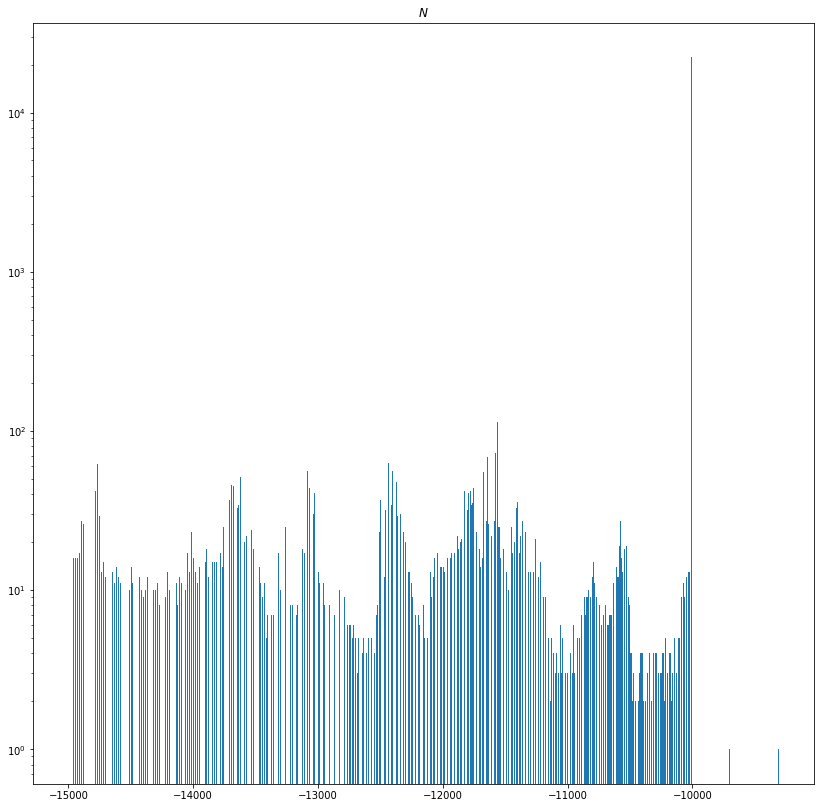

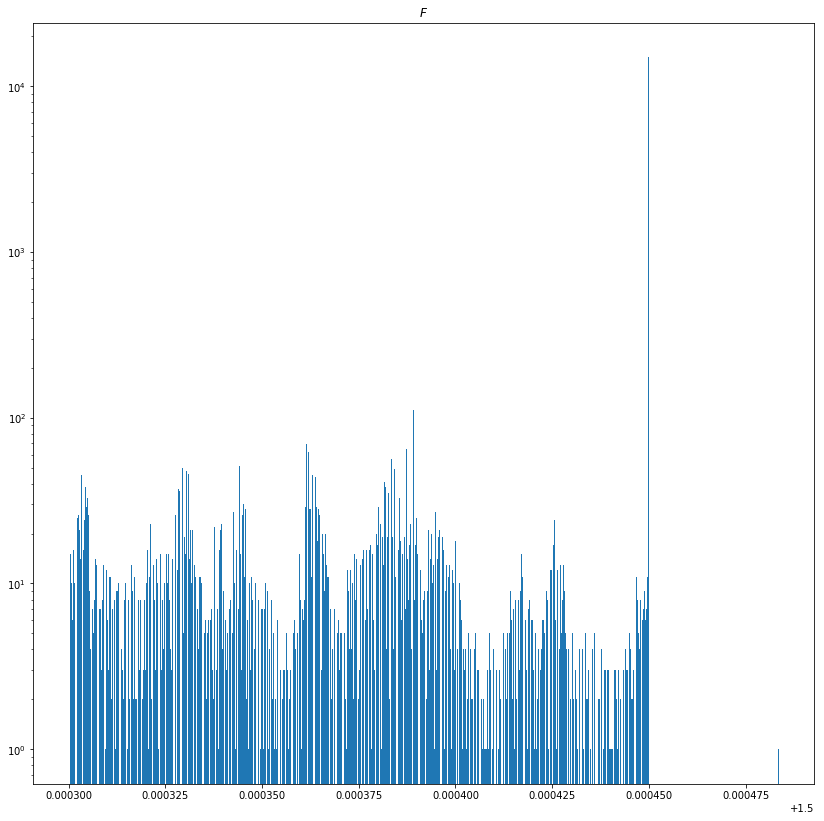

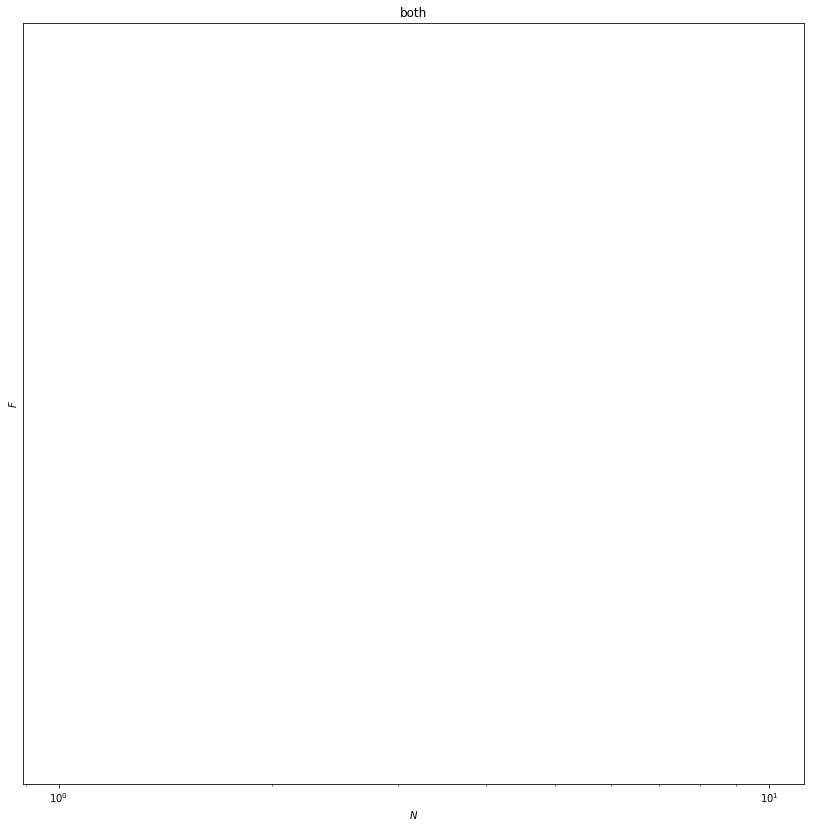

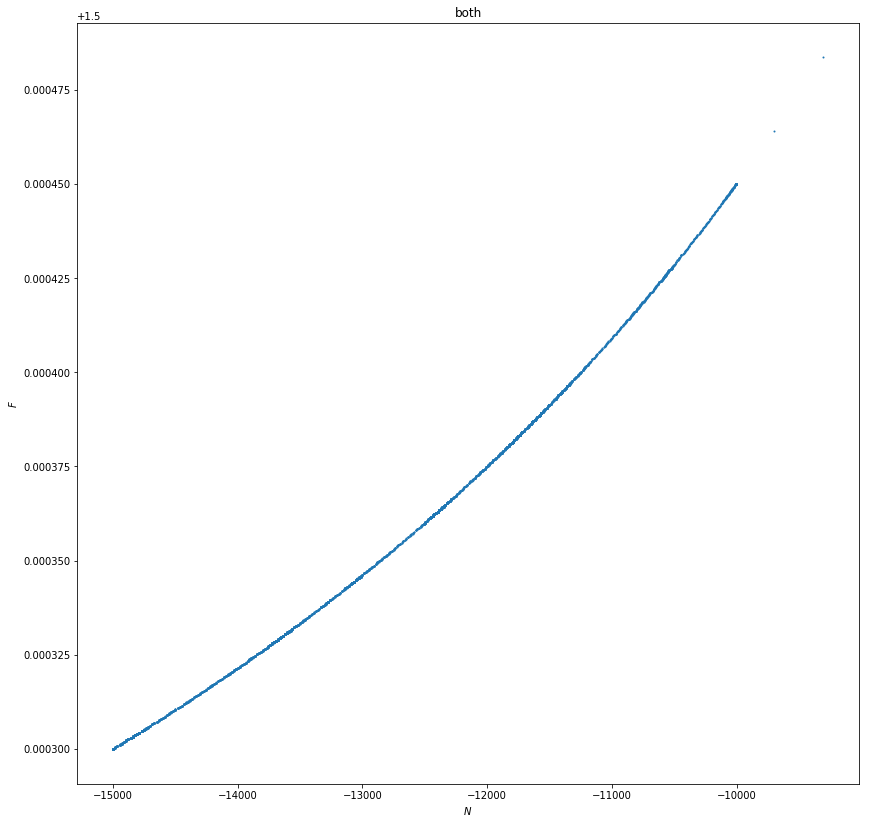

In [106]:
# showing plots with n and f
%matplotlib inline
# axes[0].plot(x22s, np.zeros_like(x22s), 'x')
fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$N$')
plt.hist(ns, bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('$F$')
plt.hist(fs, bins=1000)

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$N$')
plt.ylabel('$F$')
plt.loglog(ns, fs, 'o', markersize=1)
plt.show()

fig = plt.figure(figsize=(14, 14))
plt.title('both')
plt.xlabel('$N$')
plt.ylabel('$F$')
plt.plot(ns, fs, 'o', markersize=1)
plt.show()

In [ ]:
# fat clip, which I know precisely, is more noisy, near clip is more clear, taking value of the most frequent bin in histogram should suffice
bins = np.linspace(np.min(ns), np.max(ns), num=1000)
#print(bins)
inds = np.digitize(ns, bins)
print(inds)
print(np.sort(np.bincount(inds)))
print(np.argmax(np.bincount(inds)))
print(bins[np.argmax(np.bincount(inds))])
print(bins[np.argmax(np.bincount(inds)) - 1])
print(bins[np.argmax(np.bincount(inds)) + 1])

print('mean: ', np.mean(ns))
print('median: ', np.median(ns))


In [ ]:
# experimenting with generated matrices
my_proj = construct_proj_matrix()
proj = projs[0]
print('my_proj')
print(my_proj)
print('proj')
print(proj)
print('diff')
print(my_proj - proj)
print('diff sum')
print(np.sum(abs(my_proj - proj)))


### inspecting view matrices

In [158]:
def construct_view_matrix(camera_pos, camera_rotation):
    view_matrix = np.zeros((4, 4))
    #view_matrix[0:3, 3] = camera_pos
    view_matrix[0:3, 0:3] = create_rot_matrix(camera_rotation)
    view_matrix[3, 3] = 1
    
    trans_matrix = np.eye(4)
    trans_matrix[0:3, 3] = -camera_pos
    
    #return view_matrix
    return view_matrix @ trans_matrix

def create_rot_matrix(euler):
    x = np.radians(euler[0])
    y = np.radians(euler[1])
    z = np.radians(euler[2])
    Rx = np.array([
        [1, 0, 0],
        [0, cos(x), -sin(x)],
        [0, sin(x), cos(x)]
    ], dtype=np.float)
    Ry = np.array([
        [cos(y), 0, -sin(y)],
        [0, 1, 0],
        [sin(y), 0, cos(y)]
    ], dtype=np.float)
    Rz = np.array([
        [cos(z), -sin(z), 0],
        [sin(z), cos(z), 0],
        [0, 0, 1]
    ], dtype=np.float)

    RxNew = np.array([
        [1, 0, 0],
        [0, sin(x), cos(x)],
        [0, cos(x), -sin(x)]
    ], dtype=np.float)
    RyNew = np.array([
        [cos(y), 0, -sin(y)],
        [0, 1, 0],
        [sin(y), 0, cos(y)]
    ], dtype=np.float)
    RzNew = np.array([
        [cos(z), sin(z), 0],
        [sin(z), -cos(z), 0],
        [0, 0, 1]
    ], dtype=np.float)
    
    #derivation of Rxyz matrix is here https://www.symbolab.com/solver/matrix-multiply-calculator/%5Cbegin%7Bpmatrix%7D1%260%260%5C%5C%20%20%200%26cos%5Cleft(x%5Cright)%26-sin%5Cleft(x%5Cright)%5C%5C%20%20%200%26sin%5Cleft(x%5Cright)%26cos%5Cleft(x%5Cright)%5Cend%7Bpmatrix%7D%5Cbegin%7Bpmatrix%7Dcos%5Cleft(y%5Cright)%260%26sin%5Cleft(y%5Cright)%5C%5C%20%20%200%261%260%5C%5C%20%20-sin%5Cleft(y%5Cright)%20%260%26cos%5Cleft(y%5Cright)%5Cend%7Bpmatrix%7D%5Cbegin%7Bpmatrix%7Dcos%5Cleft(z%5Cright)%26-sin%5Cleft(z%5Cright)%260%5C%5C%20sin%5Cleft(z%5Cright)%26cos%5Cleft(z%5Cright)%260%5C%5C%200%260%261%5Cend%7Bpmatrix%7D
    Rzyx = np.array([
                [cos(x)*cos(y), cos(x)*sin(y)*sin(z) - sin(x)*cos(z), cos(x)*sin(y)*cos(z) + sin(x)*sin(z)],
                [cos(x)*cos(y), cos(x)*sin(y)*sin(z) + cos(x)*cos(z), sin(x)*sin(y)*cos(z) - cos(x)*sin(z)],
                [-sin(y), cos(y)*sin(z), cos(y)*cos(z)],
        ], dtype=np.float)
    Rxyz = np.array([
                [cos(y)*cos(z), - cos(y)*sin(z), sin(y)],
                [sin(x)*sin(y)*cos(z) + cos(x)*sin(z), cos(x)*cos(z) - sin(x)*sin(y)*sin(z), -sin(x)*cos(y)],
                [sin(x)*sin(z) - cos(x)*sin(y)*cos(z), cos(x)*sin(y)*sin(z) + sin(x)*cos(z), cos(x)*cos(y)],
        ], dtype=np.float)
    RxyzNew = np.array([
                [cos(y)*cos(z),                        cos(y)*sin(z),        -sin(y)],
                [0,                                                0,  cos(x)*cos(y)],
                [cos(x)*sin(z) - sin(x)*sin(y)*cos(z),             0, -sin(x)*cos(y)],
        ], dtype=np.float)
    # print('Rx\n', Rx)
    # print('Ry\n', Ry)
    # print('Rz\n', Rz)
    result = Rx @ Ry @ Rz
    resultNew = RxNew @ RyNew @ RzNew
    # print('result\n', result)
    #print('resultNew\n', resultNew)
    # print('Rzyx\n', Rzyx)
    # print('Rxyz\n', Rxyz)
    # print('RxyzNew\n', RxyzNew)
    return resultNew

def calc_view_matrix_params(view):
    trans = view[0:3, 3]
    rot_mat = view[0:3, 0:3]
    return trans, rot_mat

In [221]:
res = results[254]

view_matrix = res['view_matrix']
proj_matrix = res['proj_matrix']
pos = res['camera_pos']
rot = res['camera_rot']
direc = res['camera_direction']
proj_matrix_calc = construct_proj_matrix()
with printoptions(precision=6, suppress=True):
    view_matrix_calc = construct_view_matrix(pos, rot)
    print('view_matrix_rotation\n', view_matrix[0:3, 0:3])
    print('view_matrix\n', view_matrix)
    print('view_matrix_calc\n', view_matrix_calc)
    print('diff\n', np.abs(view_matrix - view_matrix_calc))
    print('diff sum\n', np.sum(abs(view_matrix - view_matrix_calc)))

    print('pos\n', pos)
    print('pos length\n', np.linalg.norm(pos))
    print('rot_vec\n', rot)
    print('proj_matrix\n', proj_matrix)
    print('proj_matrix_calc\n', proj_matrix_calc)
    print('diff: ', np.sum(np.abs(proj_matrix - proj_matrix_calc)))
    


view_matrix_rotation
 [[ 0.631192  0.77562   0.003312]
 [ 0.000261 -0.004482  0.99999 ]
 [ 0.775626 -0.631185 -0.003031]]
view_matrix
 [[    0.631192     0.77562      0.003312  1603.629576]
 [    0.000261    -0.004482     0.99999    -13.503249]
 [    0.775626    -0.631185    -0.003031  1198.000205]
 [    0.           0.           0.           1.      ]]
view_matrix_calc
 [[   -0.775912     0.630829     0.003983 -1207.084187]
 [    0.005434     0.00037      0.999985    -1.151756]
 [    0.630818     0.775922    -0.003715  1595.136766]
 [    0.           0.           0.           1.      ]]
diff
 [[    1.407104     0.144791     0.000671  2810.713764]
 [    0.005173     0.004852     0.000005    12.351493]
 [    0.144808     1.407107     0.000683   397.136561]
 [    0.           0.           0.           0.      ]]
diff sum
 3223.31701133
pos
 [-1942.825684  -476.237305    11.88518 ]
pos length
 2000.37868033
rot_vec
 [   0.212844   -0.228211  140.888321]
proj_matrix
 [[ 1.210067 -0.       

In [97]:
trans, rot_mat = calc_view_matrix_params(view_matrix)

In [ ]:
print('trans\n', trans)
print('trans length\n', np.linalg.norm(trans))
print('rot\n', rot)

In [34]:
a, b, c = rot
rot_mat_calc = np.array([
    [cos(a)*cos(b), cos(a)*sin(b)*sin(c) - sin(a)*cos(c), cos(a)*sin(b)*cos(c) + sin(a)*sin(c)],
    [cos(a)*cos(b), cos(a)*sin(b)*sin(c) + cos(a)*cos(c), sin(a)*sin(b)*cos(c) - cos(a)*sin(c)],
    [-sin(b), cos(b)*sin(c), cos(b)*cos(c)],
])
print('rot_mat calculated\n', rot_mat_calc)

rot_mat calculated
 [[ 0.95498322  0.1808363  -0.23517074]
 [ 0.95498322  0.92047784 -0.13978782]
 [ 0.2019037   0.18460988  0.96184931]]


In [11]:
# Checks if a matrix is a valid rotation matrix.
import math

def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6


def rotationMatrixToEulerAngles(R): 
    assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [13]:
euler = rotationMatrixToEulerAngles(view_matrix[0:3, 0:3])
print('euler angles from view matrix\n', euler)
print('euler angles degrees\n', np.degrees(euler))
print('rot_vec\n', rot)
print('direction_vec\n', direc)


euler angles from view matrix
 [-1.56466191 -0.88058475 -0.00827865]
euler angles degrees
 [-89.64852359 -50.45378972  -0.47433161]
rot_vec
 [ -0.22378571  -0.20330127  50.45510864]
direction_vec
 [-0.77112007  0.63667774 -0.00390579]


In [ ]:
## todo: možná zkusit zjistit něco -sin(beta), a něco z toho vyinženýruju

In [22]:
position_rotated = rot_mat @ pos 
print('position_rotated\n', position_rotated)
print('trans_in_view\n', trans)

position_rotated
 [-1612.33820849    22.32620667 -1233.75748235]
trans_in_view
 [ 1612.33813477   -22.32620621  1233.75744629]


In [65]:
# x20 = -sin(rot[1])
x20 = (view_matrix.T)[2, 0]
print('view_matrix[2, 0]\n', x20)
print('rot[1]', rot[1])
x20_calc_1 = -sin(rot[1])
print('-sin(rot[1])', x20_calc_1)
x20_calc_2 = -sin(radians(rot[1]))
print('-sin(radians(rot[1]))', x20_calc_2)
x20_calc_3 = -sin(direc[1])
print('-sin(direc[1])', x20_calc_3)
x20_calc_4 = -sin(radians(direc[1]))
print('-sin(radians(direc[1]))', x20_calc_4)
with printoptions(precision=6, suppress=True):
    print('rot_mat from view\n', rot_mat)

view_matrix[2, 0]
 0.00354826892726
rot[1] -0.203301265836
-sin(rot[1]) 0.20190370264482224
-sin(radians(rot[1])) 0.0035482690166869987
-sin(direc[1]) -0.5945273814806267
-sin(radians(direc[1])) -0.011111894187406105
rot_mat from view
 [[ 0.636679  0.771121  0.003548]
 [-0.005271 -0.000249  0.999986]
 [ 0.771111 -0.636688  0.003906]]


In [47]:
b_calc = asin(-x20)
print('b_calc\n', b_calc)
print('b_calc degrees\n', degrees(b_calc))


b_calc
 -0.8805847316073612
b_calc degrees
 -50.45378862476214


In [57]:
print('rotations shape', rotations.shape)
print('rotations min: ', np.min(rotations, axis=0))
print('rotations max: ', np.max(rotations, axis=0))
print('positions min: ', np.min(positions, axis=0))
print('positions max: ', np.max(positions, axis=0))
print('directions min: ', np.min(directions, axis=0))
print('directions max: ', np.max(directions, axis=0))


rotations shape (33293, 3)
rotations min:  [ -19.91777229  -13.07099438 -179.99897766]
rotations max:  [  12.65440559    7.11031914  179.99887085]
positions min:  [-1990.19006348 -2616.36279297     9.95022392]
positions max:  [ 2543.70141602  -431.82077026   136.6348877 ]
directions min:  [-0.99999994 -0.99999994 -0.34067121]
directions max:  [ 0.99999994  0.99999994  0.21906984]


## testing if matrix fits for all loaded matrices

In [217]:
diffs_sum = np.zeros((0))
diffs = np.zeros((4, 4, 0))
for i, res in enumerate(results):
    view_matrix = res['view_matrix']
    pos = res['camera_pos']
    rot = res['camera_rot']
    view_matrix_calc = construct_view_matrix(pos, rot)
    diff = np.abs(view_matrix - view_matrix_calc)
    diff_sum = np.sum(np.abs(view_matrix - view_matrix_calc))
    #if (np.abs(diff[0:3, 0:3]) > 1e-2).any():
    #    print(i, '\n', diff, '\n', diff_sum)
    #diffs[:, :, i] = diff
    #diffs_sum[i] = diff_sum
    diffs = np.append(diffs, diff[:, :, np.newaxis], axis=2)
    diffs_sum = np.append(diffs_sum, diff_sum)

print('diffs shape: ', diffs.shape)
print('diffs mean\n', np.mean(diffs, axis=2))
print('diffs sum\n', np.sum(diffs, axis=2))
print('diffs sum mean\n', np.mean(diffs_sum))
print('diffs sum sum\n', np.sum(diffs_sum))

# and now filtering out view matrices in records where projection matrix is corrupted
filtered_diffs_sum = np.zeros((0))
filtered_diffs = np.zeros((4, 4, 0))
proj_matrix_calc = construct_proj_matrix()
for i, res in enumerate(results):
    proj_matrix = res['proj_matrix']
    if np.sum(np.abs(proj_matrix - proj_matrix_calc)) > 1e-3:
        continue
    view_matrix = res['view_matrix']
    pos = res['camera_pos']
    rot = res['camera_rot']
    view_matrix_calc = construct_view_matrix(pos, rot)
    diff = np.abs(view_matrix - view_matrix_calc)
    diff_sum = np.sum(np.abs(view_matrix - view_matrix_calc))
    if (np.abs(diff[0:3, 0:3]) > 1e-2).any():
        print(i, '\n', diff, '\n', diff_sum)
    #diffs[:, :, i] = diff
    #diffs_sum[i] = diff_sum
    filtered_diffs = np.append(filtered_diffs, diff[:, :, np.newaxis], axis=2)
    filtered_diffs_sum = np.append(filtered_diffs_sum, diff_sum)

print('filtered diffs shape: ', filtered_diffs.shape)
print('diffs mean\n', np.mean(filtered_diffs, axis=2))
print('filtered diffs sum\n', np.sum(filtered_diffs, axis=2))
print('filtered diffs sum mean\n', np.mean(filtered_diffs_sum))
print('filtered diffs sum sum\n', np.sum(filtered_diffs_sum))


diffs shape:  (4, 4, 33293)
diffs mean
 [[  1.04017172e-01   5.56713130e-02   1.34687947e-02   2.33394093e+02]
 [  4.78576431e-02   4.57973320e-02   3.74443964e-02   6.50571415e+01]
 [  5.95988468e-02   9.44011008e-02   6.56149101e-02   1.56757253e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]]
diffs sum
 [[  3.46304369e+03   1.85346502e+03   4.48416581e+02   7.77038955e+06]
 [  1.59332451e+03   1.52473057e+03   1.24663629e+03   2.16594741e+06]
 [  1.98422441e+03   3.14289585e+03   2.18451720e+03   5.21891922e+06]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]]
diffs sum mean
 455.732359231
diffs sum sum
 15172697.4359
254 
 [[  1.40710377e+00   1.44790528e-01   6.71041289e-04   2.81071376e+03]
 [  5.17324891e-03   4.85197772e-03   4.75898889e-06   1.23514931e+01]
 [  1.44808332e-01   1.40710663e+00   6.83491504e-04   3.97136561e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 3223.31701133
450 
 [[  1.4

7843 
 [[  3.85825980e-01   1.36404707e+00   7.31900977e-04   3.01073912e+03]
 [  1.19441464e-01   1.58174600e-02   9.52480551e-06   1.85264324e+02]
 [  1.35891850e+00   3.85891930e-01   6.50699557e-06   2.62604380e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 5825.67792869
8773 
 [[  1.09746535e+00   8.88624791e-01   1.05093493e-04   6.81251153e+02]
 [  2.29083630e-02   3.67233567e-02   1.95127633e-06   1.28213997e+02]
 [  8.88345282e-01   1.09686361e+00   5.28233749e-05   4.13803525e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 4951.53149515
9289 
 [[  6.37988243e-01   1.26199006e+00   7.48466666e-04   2.08620192e+03]
 [  2.00045563e-01   1.04829369e-01   4.14267132e-04   5.92465732e+02]
 [  1.24603711e+00   6.29323610e-01   2.54967865e-03   3.62469090e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 6307.44247976
9650 
 [[  1.00060441e+00   9.80198199e-01   4.63505471e-04   3.99707698e+03

12818 
 [[  7.19219227e-01   1.22248859e+00   1.51078811e-04   3.09823452e+03]
 [  1.31965559e-01   3.84398133e-02   2.15274169e-05   1.81698735e+02]
 [  1.21581868e+00   7.18992583e-01   1.89710432e-04   1.14725639e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 4431.23693347
12951 
 [[  2.30339622e-01   1.37885799e+00   2.77330107e-03   1.54533990e+03]
 [  4.68400545e-01   6.62733004e-02   1.57020394e-03   9.59294807e+02]
 [  1.29691586e+00   2.20965040e-01   4.29446376e-03   2.71769637e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 5226.00147054
12955 
 [[  1.19484892e-01   1.39695503e+00   2.04895551e-03   1.77567742e+03]
 [  4.12428892e-01   3.34876077e-02   5.56901879e-03   8.09063046e+02]
 [  1.33455381e+00   1.14728909e-01   1.80184862e-02   2.63602794e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 5224.20567993
12962 
 [[  1.68184824e-02   1.40520628e+00   2.91725441e-04   2.03780666

17064 
 [[  1.27401212e-01   1.40703886e+00   3.03405595e-05   5.98033850e+02]
 [  1.40225202e-02   6.50064973e-02   4.31793687e-07   1.08736008e+01]
 [  1.40851647e+00   1.27914706e-01   1.69170629e-04   3.03507960e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 3647.13714694
17312 
 [[  1.84160775e-01   1.40075776e+00   3.84573198e-05   7.24403577e+02]
 [  1.22244330e-01   4.65755018e-02   2.53550375e-06   1.97582417e+02]
 [  1.39680437e+00   1.88758160e-01   9.86760413e-06   2.80717304e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 3732.49838927
17782 
 [[  3.85660462e-01   1.36061164e+00   8.65655425e-05   7.99068564e+02]
 [  4.36327056e-02   5.17663849e-04   2.61807484e-06   6.73602631e+01]
 [  1.35995972e+00   3.85828804e-01   6.40411236e-05   2.47079850e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 3340.76369649
18193 
 [[  1.31551736e+00   5.19149808e-01   8.26394530e-04   2.27014898

27532 
 [[  9.60728996e-01   1.03778591e+00   3.13374125e-11   4.30430885e+02]
 [  1.42544727e-02   1.25442878e-02   1.91202431e-08   2.57292224e+01]
 [  1.03768811e+00   9.60647212e-01   1.53124097e-10   1.93576555e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 2395.94931145
27603 
 [[  1.03778571e+00   9.60728993e-01   3.36811651e-11   1.93593688e+03]
 [  1.25442877e-02   1.42544697e-02   1.91202211e-08   6.32746401e+00]
 [  9.60647209e-01   1.03768794e+00   1.53123802e-10   4.30383883e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 2376.67187777
27833 
 [[  9.52683534e-01   1.04517645e+00   1.81885054e-10   4.92373450e+02]
 [  4.78238865e-02   4.22440899e-02   3.50256973e-08   8.85671555e+01]
 [  1.04408224e+00   9.51746996e-01   4.91243005e-09   1.97696996e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 2561.99431874
28568 
 [[  1.00005599e+00   1.00042762e+00   2.35905134e-04   2.13840404

32988 
 [[  1.40677804e+00   1.36180966e-01   9.69406007e-10   2.88618534e+02]
 [  4.74600475e-02   2.12402847e-02   3.48526951e-08   1.27017844e+01]
 [  1.36829155e-01   1.40748104e+00   7.02622949e-10   1.92740068e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]] 
 2231.87696424
filtered diffs shape:  (4, 4, 29345)
diffs mean
 [[  6.06154739e-03   8.03296197e-03   1.98311414e-06   1.35432066e+01]
 [  4.87699801e-04   2.45999715e-04   7.13106597e-07   8.28113068e-01]
 [  8.01034569e-03   6.05593828e-03   5.07171146e-06   1.32021128e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]]
filtered diffs sum
 [[  1.77876108e+02   2.35727269e+02   5.81944845e-02   3.97425398e+05]
 [  1.43115507e+01   7.21886164e+00   2.09261131e-02   2.43009780e+04]
 [  2.35063594e+02   1.77711509e+02   1.48829373e-01   3.87416000e+05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]]
filtered diffs sum mean
 27.6023347348
filtered diff

### printing histograms for errors

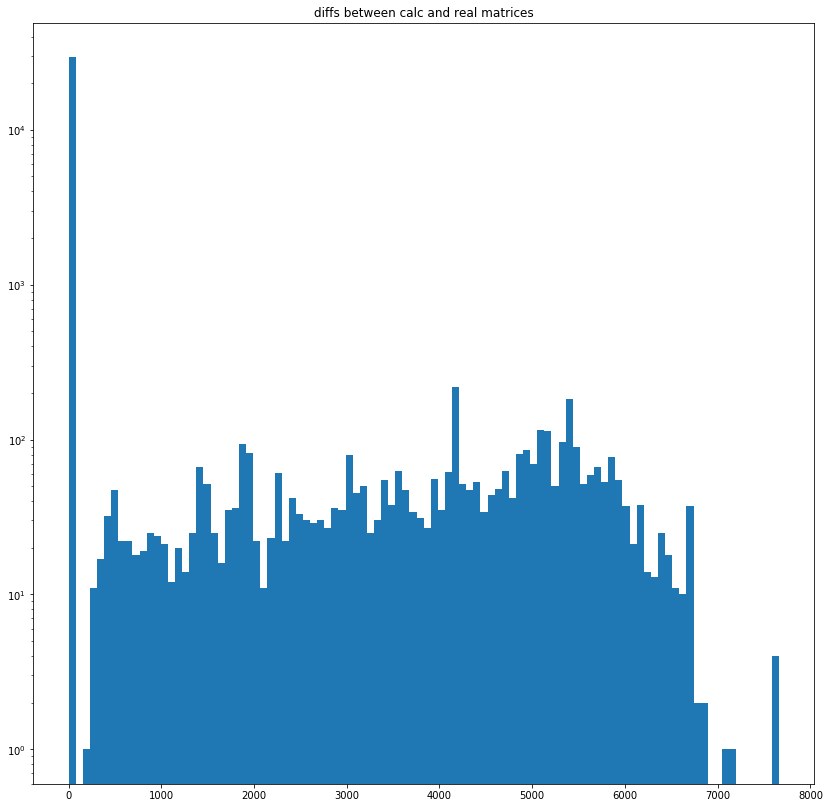

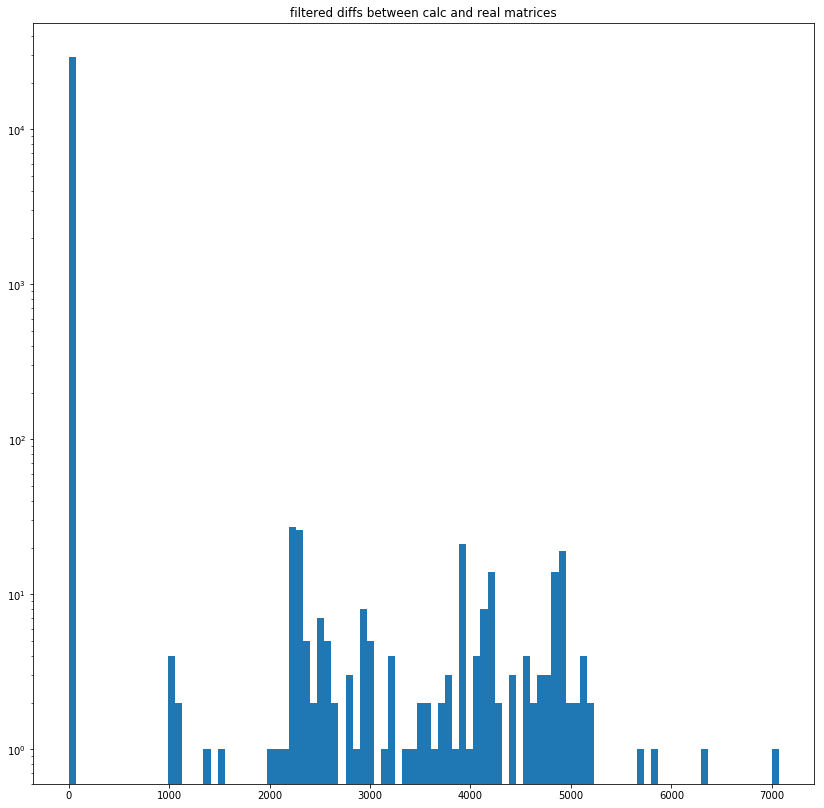

count of elements:  33293
count of diffs bigger than 1:  3897
ratio of diffs bigger than 1:  0.117051632475
count of filtered elements:  29345
count of filtered diffs bigger than 1:  232
ratio of filtered diffs bigger than 1:  0.00790594649855


In [220]:
fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('diffs between calc and real matrices')
plt.hist(diffs_sum, bins=100)

fig = plt.figure(figsize=(14, 14))
plt.yscale('log', nonposy='clip')
plt.title('filtered diffs between calc and real matrices')
plt.hist(filtered_diffs_sum, bins=100)

plt.show()
print('count of elements: ', np.size(diffs_sum))
print('count of diffs bigger than 1: ', np.sum(diffs_sum > 1))
print('ratio of diffs bigger than 1: ', np.sum(diffs_sum > 1) / np.size(diffs_sum))
print('count of filtered elements: ', np.size(filtered_diffs_sum))
print('count of filtered diffs bigger than 1: ', np.sum(filtered_diffs_sum > 1))
print('ratio of filtered diffs bigger than 1: ', np.sum(filtered_diffs_sum > 1) / np.size(filtered_diffs_sum))